## UNET Receptive Field via "Point Spread Function" measurment

I first saw this idea in the stardist code.  An explanation and further references to the important parts of the stardist code can be found [here](https://github.com/True-North-Intelligent-Algorithms/notebooks-and-napari-widgets-for-dl/blob/main/docs/20_scale/10_stardist_receptive_field%202D.ipynb)

The idea is to measure receptive field of UNET emprically by applying the untrained network to an image of a single point then looking at the extent in pixels of the 'non-zero' outputs.  It is a bit tricky because you have to be careful about bias terms.  

In [40]:
import torch
from monai.networks.nets import UNet, BasicUNet
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import imshow_multi2d
import numpy as np

## First we create some UNETs using Monai

We try ```BasicUNet``` and then ```UNet``` with different numbers of layers.

In [41]:
basic_unet = BasicUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    norm=None,
    act=("LeakyReLU", {"negative_slope": 0.01, "inplace": True}),
    bias=False,
    dropout=0.0,
)

net_4 = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(32, 32, 64, 128, 256),  # NO FINAL 32 in main UNet (it's for output later)
    strides=(2, 2, 2, 2),
    num_res_units=0,  
    act=("LeakyReLU", {"negative_slope": 0.01, "inplace": True}),
    #norm="batch",
    norm=None, #("batch", {"affine": False, "track_running_stats": False}),
    dropout=0.0,
    bias= False,
)


net_5 = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(32, 32, 64, 128, 256, 512),  # NO FINAL 32 in main UNet (it's for output later)
    strides=(2, 2, 2, 2, 2),
    num_res_units=0,  
    act=("LeakyReLU", {"negative_slope": 0.01, "inplace": True}),
    #norm="batch",
    norm=None, #("batch", {"affine": False, "track_running_stats": False}),
    dropout=0.0,
    bias= False,
)

net_6 = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(32, 32, 64, 128, 256, 512, 1024),  # NO FINAL 32 in main UNet (it's for output later)
    strides=(2, 2, 2, 2, 2,2),
    num_res_units=0,  
    act=("LeakyReLU", {"negative_slope": 0.01, "inplace": True}),
    #norm="batch",
    norm=None,
    #norm=("batch", {"affine": False, "track_running_stats": False}),
    dropout=0.0,
    bias= False,
)



BasicUNet features: (32, 32, 64, 128, 256, 32).


## Now create a point image

We are going to use the point as input to the untrained networks.  This will show us how many pixels information from a single point propagates. 

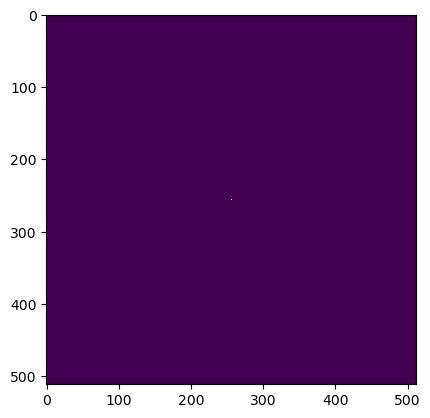

In [42]:
size = 512
# Define image size
height, width = size, size  # or any size you want

# Create an empty image (all zeros)
image = torch.zeros((height, width), dtype=torch.float32)

# Set the center point to 1
center_y, center_x = height // 2, width // 2
image[center_y, center_x] = 1.

plt.imshow(image)

In [43]:
basic_unet.eval()
net_4.eval()
net_5.eval()
net_6.eval()

with torch.no_grad():
    out_basic = basic_unet(image.unsqueeze(0).unsqueeze(0))
    out_4 = net_4(image.unsqueeze(0).unsqueeze(0))
    out_5 = net_5(image.unsqueeze(0).unsqueeze(0))
    out_6 = net_6(image.unsqueeze(0).unsqueeze(0))


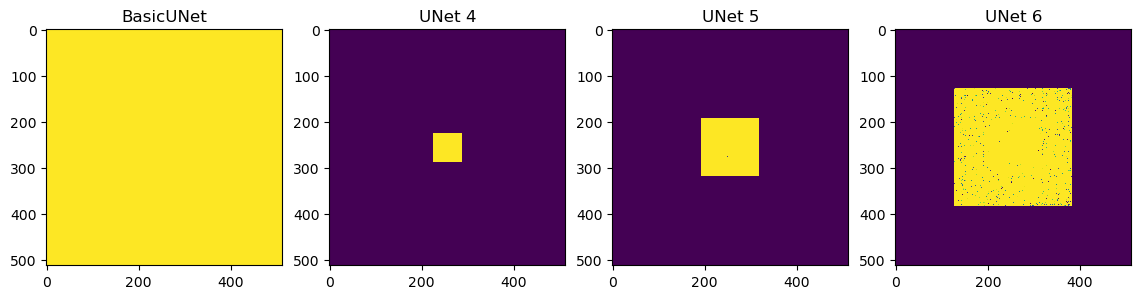

In [56]:
outs = [out_basic, out_4, out_5, out_6]
titles = ['BasicUNet', 'UNet 4', 'UNet 5', 'UNet 6']
abs = [np.abs(out.squeeze().detach().numpy()) for out in outs]
abs = [a-np.min(a) for a in abs]

vmaxs = [np.min(out)+np.max(out)/10000000000 for out in abs]
fig = imshow_multi2d(abs, titles, 1, len(abs), vmax=vmaxs, width = 14)

## Let's check min and max of results 

In [52]:
abs[0].min(), abs[0].max(), abs[1].min(), abs[1].max()

(0.0, 0.008250043, 0.0, 0.34225145)

In [23]:
for name, param in net_4.named_parameters():
    print(name, torch.sum(torch.abs(param)))

model.0.conv.weight tensor(48.5596, grad_fn=<SumBackward0>)
model.1.submodule.0.conv.weight tensor(273.3379, grad_fn=<SumBackward0>)
model.1.submodule.1.submodule.0.conv.weight tensor(539.6789, grad_fn=<SumBackward0>)
model.1.submodule.1.submodule.1.submodule.0.conv.weight tensor(1536.3944, grad_fn=<SumBackward0>)
model.1.submodule.1.submodule.1.submodule.1.submodule.conv.weight tensor(4349.6426, grad_fn=<SumBackward0>)
model.1.submodule.1.submodule.1.submodule.2.conv.weight tensor(4614.5205, grad_fn=<SumBackward0>)
model.1.submodule.1.submodule.2.conv.weight tensor(1087.8169, grad_fn=<SumBackward0>)
model.1.submodule.2.conv.weight tensor(543.5225, grad_fn=<SumBackward0>)
model.2.conv.weight tensor(97.1102, grad_fn=<SumBackward0>)


In [22]:
for name, param in basic_unet.named_parameters():
    print(name, torch.sum(torch.abs(param)))

conv_0.conv_0.conv.weight tensor(50.1743, grad_fn=<SumBackward0>)
conv_0.conv_1.conv.weight tensor(273.6124, grad_fn=<SumBackward0>)
down_1.convs.conv_0.conv.weight tensor(272.3649, grad_fn=<SumBackward0>)
down_1.convs.conv_1.conv.weight tensor(271.6090, grad_fn=<SumBackward0>)
down_2.convs.conv_0.conv.weight tensor(541.5311, grad_fn=<SumBackward0>)
down_2.convs.conv_1.conv.weight tensor(766.3395, grad_fn=<SumBackward0>)
down_3.convs.conv_0.conv.weight tensor(1535.4630, grad_fn=<SumBackward0>)
down_3.convs.conv_1.conv.weight tensor(2169.4675, grad_fn=<SumBackward0>)
down_4.convs.conv_0.conv.weight tensor(4343.9419, grad_fn=<SumBackward0>)
down_4.convs.conv_1.conv.weight tensor(6140.5630, grad_fn=<SumBackward0>)
upcat_4.upsample.deconv.weight tensor(2891.7864, grad_fn=<SumBackward0>)
upcat_4.upsample.deconv.bias tensor(2.6397, grad_fn=<SumBackward0>)
upcat_4.convs.conv_0.conv.weight tensor(3071.0486, grad_fn=<SumBackward0>)
upcat_4.convs.conv_1.conv.weight tensor(2171.6082, grad_fn=<Sum